This notebook lays out the initial set of analyses performed by RP using multidimensional item response theory (MIRT) on a subset of the UH2 discovery sample.  

For the analyses of the survey data, we have discussed two potential approaches, to be pursued in parallel.  One is to examine the survey results using the standard subscales associated with each survey; that approach is not addressed here.  The second, which I focus on here, is to estimate a set of factors without regard to the inventories from which the surveys come, in essence treating them as a "bag of items".  

I started with data for 158 subjects from the discovery sample on all of the survey items (limited to the surveys that have reasonable ordinal scales).  This gave 507 items.  In order to make these a bit more tractable to deal with, I extracted the items separately for each survey and saved them to separate files, along with the metadata for each survey.  These are all saved according to the (still incomplete) [BIDS standard](http://bids.neuroimaging.io) for phenotypic data.  




In [1]:
# first, set up our imports and configuration

import os,glob
import json
import importlib

import pandas
import networkx as nx
import numpy
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, HTML
pandas.set_option('max_colwidth', 100)

from show_image import showPDF

import process_itemlevel
importlib.reload(process_itemlevel)


%matplotlib inline


In [2]:
data,basedir=process_itemlevel.get_data()
survey_items=process_itemlevel.get_survey_items(data)
survey_metadata,metadatadir=process_itemlevel.save_metadata(survey_items)
data=process_itemlevel.add_survey_item_labels(data)
datadir=process_itemlevel.save_data(data,survey_metadata)



In [3]:
print('Processed the following surveys for %d subjects:'%len(data.worker.unique()))
surveyinfo=[]
for k in survey_metadata.keys():
    surveyinfo.append([k.replace('_survey',''),len(survey_metadata[k])-1])
df=pandas.DataFrame(surveyinfo,columns=['SurveyName','NumberOfItems'])
display(df)
print('')
print('data stored to %s'%datadir)
print('metadata stored to %s'%metadatadir)

Processed the following surveys for 158 subjects:


,SurveyName,NumberOfItems
0,time_perspective,56
1,brief_self_control,13
2,eating,18
3,bis_bas,24
4,upps_impulsivity,59
5,future_time_perspective,10
6,self_regulation,30
7,dickman,23
8,grit_scale,8
9,dospert_rt,30



data stored to /Users/poldrack/code/Self_Regulation_Ontology/discovery_survey_analyses/surveydata
metadata stored to /Users/poldrack/code/Self_Regulation_Ontology/metadata


Create a file containing the item ids and text, for use in later R analyses.

In [4]:

with open('all_survey_metadata.json', encoding='utf-8') as data_file:
        md = json.loads(data_file.read())

all_metadata={}
for measure in md.keys():
    for k in md[measure].keys():
        all_metadata[k]=md[measure][k]

with open('variable_key.txt','w') as f:
    for k in all_metadata.keys():
        f.write('%s\t%s\n'%(k,all_metadata[k]['Description']))

### MIRT analyses

I then used the R mirt package to run exploratory multidimensional IRT analyses, using a 2PL model with the Metropolis-Hastings Robbins-Monro (MHRM) algorithm so that I could successfully fit the larger models.  In the example shown below, I fit models with dimensionalities from 1 to 10.  I then characterized each dimension by examining the items that had the highest/lowest scores on each one and giving a summary label (which was sometimes difficult, in which case I just used "unknown").  





In [5]:
%load_ext rpy2.ipython
%R require('mirt')

if not os.path.exists('mirt_rdata'):
    os.mkdir('mirt_rdata')

/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: mirt

  warnings.warn(x, RRuntimeWarning)
/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)


The following is from run_mirt.R which was used to the run the models at various dimensionalities on the TACC Wrangler data analytics cluster. It will take quite a while on a laptop system. For this example, we just use two latent dimensions, so we can turn off the MHRM sampler, which speeds things up quite a bit.

In [6]:
%%R

library(mirt)
library(parallel)
mirtCluster(2)
args <- commandArgs(TRUE)

if (length(args)<1) {
ncomps=2
} else {
  ncomps=as.integer(args[1])
}


d=read.csv('surveydata.csv')
d$worker=NULL
m=mirt(d,ncomps) #,verbose=FALSE,method='MHRM')

save(m,file=sprintf('mirt_%ddims_example.Rdata',ncomps))

/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Item re-scored so that all values are within a distance of 1

  warnings.warn(x, RRuntimeWarning)


Iteration: 2, Log-Lik: -89744.166, Max-Change: 0.00001

Now let's load in the models from each dimensionality (run on the cluster) and save their latent scores so that we can load them into python and have a look. (this is adapted from summarize_mirt.R)

In [7]:
datfiles=glob.glob('rdata_files_wrangler/*Rdata')
compnums=[int(i.split('/')[1].replace('mirt_','').replace('dims.Rdata','')) for i in datfiles]
compnums.sort()

if not os.path.exists('mirt_scores'):
    os.mkdir('mirt_scores')

In [8]:
%%R -i compnums -o converged
#compnums=c(1,2,3,4,5,6,8,9,10)
converged=array(dim=length(compnums))
for (i in 1:length(compnums)) {
  ncomps=compnums[i]
  load(sprintf('rdata_files_wrangler/mirt_%ddims.Rdata',ncomps))
  converged[i]=m@OptimInfo$converged
  s=summary(m,verbose=FALSE)
  scores=s$rotF
  write.table(scores,file=sprintf('mirt_scores/mirt_scores_%ddims.tsv',ncomps),sep='\t',quote=FALSE,col.names=FALSE)
}

In [9]:
# print out some convergence statistics for each model
df=pandas.DataFrame({'Dimensions':compnums,'converged':converged})
display(df)

,Dimensions,converged
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
5,6,0
6,8,0
7,9,0
8,10,0


Now let's look at the results from each model.   First we need to set up a dictionary with the subjective labels.

In [10]:
compdesc={}
compdesc[1]=['persistence']
compdesc[2]=['persistence','risktaking']
compdesc[3]=['persistence','physical risk','impulsivity']
compdesc[4]=['persistence','physical risk','impulsivity','internalizing']
compdesc[5]=['manic impulsivity','physical risk','impulsivity','internalizing',
            'persistence']
compdesc[6]=['impulsivity','physical risk','life impulsivity',
            'internalizing','persistence','planning/sentimentality']
compdesc[8]=['manic impulsivity','physical risk','dysfunctional risk',
            'internalizing','persistence','unknown','life impulsivity',
            'mindfulness']
compdesc[9]=['manic impulsivity','physical risk','financial risk','internalizing',
             'unknown','life risk','persistence','impulsivity','mindfulness']
compdesc[10]=['manic impulsivity','physical risk','financial risk','internalizing',
              'mental energy','life risk','persistence','impulsivity','mindfulness','emotion regulation']

Now let's list the items with top positive and negative scores for each latent dimension, along with the subjective label.

In [13]:

scores={}
for c in range(len(compnums)):
    ncomps=compnums[c]
    scdata=pandas.read_csv('mirt_scores/mirt_scores_%ddims.tsv'%ncomps,
                         delimiter='\t',header=None,names=['itemname']+['score%d'%i for i in range(ncomps)])
    scores[ncomps]=scdata
    print('')
    for d in range(ncomps):
        print('%d Components: Dimension %d (%s)'%(ncomps,d+1,compdesc[ncomps][d]))
        cdata=scdata.sort_values(by='score%d'%d)
        lowdata=cdata.iloc[:3,[0,d+1]]
        highdata=cdata.iloc[-3:,[0,d+1]]
        data_show=pandas.concat([lowdata,highdata])
        itemtext=[]
        for item in data_show['itemname']:
            itemtext.append(all_metadata[item]['Description'])
        data_show['itemtext']=itemtext
        display(data_show)    


1 Components: Dimension 1 (persistence)


,itemname,score0,itemtext
451,upps_impulsivity_survey_5,-0.661322,I generally like to see things through to the end.
456,upps_impulsivity_survey_10,-0.658408,I tend to give up easily.
474,upps_impulsivity_survey_28,-0.638342,I finish what I start.
263,grit_scale_survey_7,0.597594,I have difficulty maintaining my focus on projects that take more than a few months to complete.
352,self_regulation_survey_14,0.625884,I am able to accomplish goals for myself.
350,self_regulation_survey_12,0.679469,I give up quickly.



2 Components: Dimension 1 (persistence)


,itemname,score0,itemtext
456,upps_impulsivity_survey_10,-0.728669,I tend to give up easily.
451,upps_impulsivity_survey_5,-0.625341,I generally like to see things through to the end.
474,upps_impulsivity_survey_28,-0.608823,I finish what I start.
352,self_regulation_survey_14,0.611386,I am able to accomplish goals for myself.
263,grit_scale_survey_7,0.623568,I have difficulty maintaining my focus on projects that take more than a few months to complete.
350,self_regulation_survey_12,0.739256,I give up quickly.


2 Components: Dimension 2 (risktaking)


,itemname,score1,itemtext
268,impulsive_venture_survey_4,-0.850180,Do you quite enjoy taking risks?
277,impulsive_venture_survey_13,-0.833908,Do you usually think carefully before doing anything?
470,upps_impulsivity_survey_24,-0.788281,I quite enjoy taking risks.
327,mpq_control_survey_13,0.709908,I am cautious person.
329,mpq_control_survey_15,0.744643,I do the first thing that comes to mind.
318,mpq_control_survey_4,0.774862,I think before doing.



3 Components: Dimension 1 (persistence)


,itemname,score0,itemtext
451,upps_impulsivity_survey_5,-0.571170,I generally like to see things through to the end.
456,upps_impulsivity_survey_10,-0.545732,I tend to give up easily.
484,upps_impulsivity_survey_38,-0.476262,I am a person who always gets the job done.
366,self_regulation_survey_29,0.453008,"If I wanted to change, I am confident that I could do it."
352,self_regulation_survey_14,0.490509,I am able to accomplish goals for myself.
350,self_regulation_survey_12,0.571017,I give up quickly.


3 Components: Dimension 2 (physical risk)


,itemname,score1,itemtext
161,dospert_rt_survey_12,-0.541859,Going down a ski run that is beyond your ability.
269,impulsive_venture_survey_5,-0.526821,Would you enjoy parachute jumping?
473,upps_impulsivity_survey_27,-0.490267,I would enjoy parachute jumping.
46,bis_bas_survey_17,0.430405,If I think something unpleasant is going to happen I usually get pretty 'worked up.
52,bis_bas_survey_23,0.448945,I have very few fears compared to my friends.
54,bis_bas_survey_25,0.464944,I worry about making mistakes.


3 Components: Dimension 3 (impulsivity)


,itemname,score2,itemtext
271,impulsive_venture_survey_7,-0.729430,Do you generally do and say things without stopping to think?
275,impulsive_venture_survey_11,-0.718093,Are you an impulsive person?
89,dickman_survey_23,-0.706691,"Before making any important decision, I carefully weigh the pros and cons."
333,mpq_control_survey_19,0.657543,I am very level-headed.
329,mpq_control_survey_15,0.660894,I do the first thing that comes to mind.
318,mpq_control_survey_4,0.891285,I think before doing.



4 Components: Dimension 1 (persistence)


,itemname,score0,itemtext
451,upps_impulsivity_survey_5,-0.642872,I generally like to see things through to the end.
466,upps_impulsivity_survey_20,-0.619817,Once I get going on something I hate to stop.
474,upps_impulsivity_survey_28,-0.541369,I finish what I start.
34,bis_bas_survey_5,0.534629,When I am doing well at something I love to keep at it.
367,self_regulation_survey_30,0.542488,I can stick to a plan that's working well.
265,grit_scale_survey_9,0.572329,I am diligent.


4 Components: Dimension 2 (physical risk)


,itemname,score1,itemtext
269,impulsive_venture_survey_5,-0.761280,Would you enjoy parachute jumping?
473,upps_impulsivity_survey_27,-0.697431,I would enjoy parachute jumping.
169,dospert_rt_survey_20,-0.692243,Taking a skydiving class.
131,dospert_rp_survey_12,0.398703,Going down a ski run that is beyond your ability.
327,mpq_control_survey_13,0.439932,I am cautious person.
52,bis_bas_survey_23,0.473769,I have very few fears compared to my friends.


4 Components: Dimension 3 (impulsivity)


,itemname,score2,itemtext
271,impulsive_venture_survey_7,-0.772958,Do you generally do and say things without stopping to think?
89,dickman_survey_23,-0.756775,"Before making any important decision, I carefully weigh the pros and cons."
275,impulsive_venture_survey_11,-0.746971,Are you an impulsive person?
319,mpq_control_survey_5,0.655953,I stop and think.
329,mpq_control_survey_15,0.717342,I do the first thing that comes to mind.
318,mpq_control_survey_4,0.895549,I think before doing.


4 Components: Dimension 4 (internalizing)


,itemname,score3,itemtext
238,five_facet_mindfulness_survey_31,-0.649017,I think some of my emotions are bad or inappropriate and I shouldnt feel them.
222,five_facet_mindfulness_survey_15,-0.591515,I believe some of my thoughts are abnormal or bad and I shouldnt think that way.
247,five_facet_mindfulness_survey_40,-0.567339,I disapprove of myself when I have irrational ideas.
395,time_perspective_survey_5,0.572549,I often think of what I should have done differently in my life.
407,time_perspective_survey_17,0.576001,Painful past experiences keep being replayed in my mind.
441,time_perspective_survey_51,0.585172,I think about the bad things that have happened to me in the past.



5 Components: Dimension 1 (manic impulsivity)


,itemname,score0,itemtext
487,upps_impulsivity_survey_41,-0.795528,"When I get really happy about something, I tend to do things that can have bad consequences."
482,upps_impulsivity_survey_36,-0.786565,Others are shocked or worried about the things I do when I am feeling very excited.
477,upps_impulsivity_survey_31,-0.761165,Others would say I make bad choices when I am extremely happy about something.
348,self_regulation_survey_10,0.415241,I usually think before I act.
67,brief_self_control_survey_14,0.460427,I often act without thinking through all the alternatives.
329,mpq_control_survey_15,0.666814,I do the first thing that comes to mind.


5 Components: Dimension 2 (physical risk)


,itemname,score1,itemtext
269,impulsive_venture_survey_5,-0.600543,Would you enjoy parachute jumping?
266,impulsive_venture_survey_2,-0.563557,Would you enjoy water skiing?
161,dospert_rt_survey_12,-0.559187,Going down a ski run that is beyond your ability.
131,dospert_rp_survey_12,0.322914,Going down a ski run that is beyond your ability.
52,bis_bas_survey_23,0.367585,I have very few fears compared to my friends.
327,mpq_control_survey_13,0.384775,I am cautious person.


5 Components: Dimension 3 (impulsivity)


,itemname,score2,itemtext
271,impulsive_venture_survey_7,-0.415128,Do you generally do and say things without stopping to think?
234,five_facet_mindfulness_survey_27,-0.401732,I notice the smells and aromas of things.
281,impulsive_venture_survey_17,-0.378372,Do you often get involved in things you later wish you could get out of?
466,upps_impulsivity_survey_20,0.355408,Once I get going on something I hate to stop.
333,mpq_control_survey_19,0.387994,I am very level-headed.
318,mpq_control_survey_4,0.547537,I think before doing.


5 Components: Dimension 4 (internalizing)


,itemname,score3,itemtext
238,five_facet_mindfulness_survey_31,-0.593141,I think some of my emotions are bad or inappropriate and I shouldnt feel them.
222,five_facet_mindfulness_survey_15,-0.546861,I believe some of my thoughts are abnormal or bad and I shouldnt think that way.
211,five_facet_mindfulness_survey_4,-0.511833,I criticize myself for having irrational or inappropriate emotions.
395,time_perspective_survey_5,0.522945,I often think of what I should have done differently in my life.
407,time_perspective_survey_17,0.535056,Painful past experiences keep being replayed in my mind.
441,time_perspective_survey_51,0.557972,I think about the bad things that have happened to me in the past.


5 Components: Dimension 5 (persistence)


,itemname,score4,itemtext
337,mpq_control_survey_23,-0.715054,I do not have detailed plans.
338,mpq_control_survey_24,-0.665031,I have a good idea of what I'm going to do.
264,grit_scale_survey_8,-0.655881,I finish whatever I begin.
484,upps_impulsivity_survey_38,0.681798,I am a person who always gets the job done.
474,upps_impulsivity_survey_28,0.733540,I finish what I start.
451,upps_impulsivity_survey_5,0.735437,I generally like to see things through to the end.



6 Components: Dimension 1 (impulsivity)


,itemname,score0,itemtext
487,upps_impulsivity_survey_41,-0.788807,"When I get really happy about something, I tend to do things that can have bad consequences."
74,dickman_survey_8,-0.774361,I often make up my mind without taking the time to consider the situation from all angles.
89,dickman_survey_23,-0.768827,"Before making any important decision, I carefully weigh the pros and cons."
348,self_regulation_survey_10,0.510341,I usually think before I act.
67,brief_self_control_survey_14,0.618478,I often act without thinking through all the alternatives.
329,mpq_control_survey_15,0.841987,I do the first thing that comes to mind.


6 Components: Dimension 2 (physical risk)


,itemname,score1,itemtext
269,impulsive_venture_survey_5,-0.907578,Would you enjoy parachute jumping?
465,upps_impulsivity_survey_19,-0.838758,I would enjoy water skiing.
473,upps_impulsivity_survey_27,-0.829585,I would enjoy parachute jumping.
131,dospert_rp_survey_12,0.537063,Going down a ski run that is beyond your ability.
144,dospert_rp_survey_25,0.552634,Bungee jumping off a tall bridge.
327,mpq_control_survey_13,0.560827,I am cautious person.


6 Components: Dimension 3 (life impulsivity)


,itemname,score2,itemtext
172,dospert_rt_survey_23,-0.706553,Speaking your mind about an unpopular issue in a meeting at work.
178,dospert_rt_survey_29,-0.689824,Starting a new career in your mid-thirties.
171,dospert_rt_survey_22,-0.667652,Choosing a career that you truly enjoy over a more secure one.
107,dospert_eb_survey_18,0.524441,Driving a car without wearing a seat belt.
121,dospert_rp_survey_2,0.539009,Admitting that your tastes are different from those of a friend.
324,mpq_control_survey_10,0.545928,I do things on the spur of the moment.


6 Components: Dimension 4 (internalizing)


,itemname,score3,itemtext
238,five_facet_mindfulness_survey_31,-0.644443,I think some of my emotions are bad or inappropriate and I shouldnt feel them.
222,five_facet_mindfulness_survey_15,-0.584758,I believe some of my thoughts are abnormal or bad and I shouldnt think that way.
247,five_facet_mindfulness_survey_40,-0.572313,I disapprove of myself when I have irrational ideas.
395,time_perspective_survey_5,0.581004,I often think of what I should have done differently in my life.
407,time_perspective_survey_17,0.586910,Painful past experiences keep being replayed in my mind.
441,time_perspective_survey_51,0.606476,I think about the bad things that have happened to me in the past.


6 Components: Dimension 5 (persistence)


,itemname,score4,itemtext
337,mpq_control_survey_23,-0.851072,I do not have detailed plans.
264,grit_scale_survey_8,-0.820190,I finish whatever I begin.
338,mpq_control_survey_24,-0.792227,I have a good idea of what I'm going to do.
451,upps_impulsivity_survey_5,0.833533,I generally like to see things through to the end.
474,upps_impulsivity_survey_28,0.852384,I finish what I start.
484,upps_impulsivity_survey_38,0.854662,I am a person who always gets the job done.


6 Components: Dimension 6 (planning/sentimentality)


,itemname,score5,itemtext
466,upps_impulsivity_survey_20,-0.507622,Once I get going on something I hate to stop.
85,dickman_survey_19,-0.466105,I often get into trouble because I don't think before I act.
89,dickman_survey_23,-0.407446,"Before making any important decision, I carefully weigh the pros and cons."
406,time_perspective_survey_16,0.681091,I enjoy stories about how things used to be in the 'good old times.'
411,time_perspective_survey_21,0.728684,Happy memories of good times spring readily to mind.
393,time_perspective_survey_3,0.747172,"Familiar childhood sights, sounds, smells often bring back a flood of wonderful memories."



8 Components: Dimension 1 (manic impulsivity)


,itemname,score0,itemtext
487,upps_impulsivity_survey_41,-0.927108,"When I get really happy about something, I tend to do things that can have bad consequences."
496,upps_impulsivity_survey_50,-0.878128,"When I am really excited, I tend not to think of the consequences of my actions."
477,upps_impulsivity_survey_31,-0.861002,Others would say I make bad choices when I am extremely happy about something.
66,brief_self_control_survey_13,0.506177,"Sometimes I can't stop myself from doing something, even if I know it is wrong."
329,mpq_control_survey_15,0.562383,I do the first thing that comes to mind.
67,brief_self_control_survey_14,0.575821,I often act without thinking through all the alternatives.


8 Components: Dimension 2 (physical risk)


,itemname,score1,itemtext
269,impulsive_venture_survey_5,-0.849752,Would you enjoy parachute jumping?
465,upps_impulsivity_survey_19,-0.843677,I would enjoy water skiing.
493,upps_impulsivity_survey_47,-0.810386,I would enjoy the sensation of skiing very fast down a high mountain slope.
52,bis_bas_survey_23,0.489161,I have very few fears compared to my friends.
327,mpq_control_survey_13,0.498610,I am cautious person.
415,time_perspective_survey_25,0.526129,I take each day as it is rather than try to plan it out.


8 Components: Dimension 3 (dysfunctional risk)


,itemname,score2,itemtext
137,dospert_rp_survey_18,-0.680199,Driving a car without wearing a seat belt.
129,dospert_rp_survey_10,-0.571356,Having an affair with a married man/woman.
140,dospert_rp_survey_21,-0.555861,Riding a motorcycle without a helmet.
99,dospert_eb_survey_10,0.477612,Having an affair with a married man/woman.
159,dospert_rt_survey_10,0.479175,Having an affair with a married man/woman.
160,dospert_rt_survey_11,0.516380,Passing off somebody elses work as your own.


8 Components: Dimension 4 (internalizing)


,itemname,score3,itemtext
416,time_perspective_survey_26,-0.646629,The past has too many unpleasant memories that I prefer not to think about.
253,future_time_perspective_survey_7,-0.632969,I could do anything I want in the future.
254,future_time_perspective_survey_8,-0.610238,There is plenty of time left in my life to make new plans.
425,time_perspective_survey_35,0.701097,It's hard for me to forget unpleasant images of my youth.
418,time_perspective_survey_28,0.703102,I've made mistakes in the past that I wish I could undo.
441,time_perspective_survey_51,0.738657,I think about the bad things that have happened to me in the past.


8 Components: Dimension 5 (persistence)


,itemname,score4,itemtext
337,mpq_control_survey_23,-0.741592,I do not have detailed plans.
351,self_regulation_survey_13,-0.708123,I usually keep track of my progress toward my goals.
358,self_regulation_survey_20,-0.696806,I set goals for myself and keep track of my progress.
474,upps_impulsivity_survey_28,0.590270,I finish what I start.
461,upps_impulsivity_survey_15,0.614107,Unfinished tasks really bother me.
451,upps_impulsivity_survey_5,0.618253,I generally like to see things through to the end.


8 Components: Dimension 6 (unknown)


,itemname,score5,itemtext
89,dickman_survey_23,-0.629576,"Before making any important decision, I carefully weigh the pros and cons."
297,impulsive_venture_survey_33,-0.568989,Do you prefer to 'sleep on it' before making decisions?
85,dickman_survey_19,-0.531768,I often get into trouble because I don't think before I act.
381,theories_of_willpower_survey_3,0.632636,"After a strenuous mental activity, your energy is depleted and you must rest to get it refuelled..."
380,theories_of_willpower_survey_2,0.648951,"Strenuous mental activity exhausts your resources, which you need to refuel afterwards (e.g. thr..."
393,time_perspective_survey_3,0.687651,"Familiar childhood sights, sounds, smells often bring back a flood of wonderful memories."


8 Components: Dimension 7 (life impulsivity)


,itemname,score6,itemtext
172,dospert_rt_survey_23,-0.709051,Speaking your mind about an unpopular issue in a meeting at work.
171,dospert_rt_survey_22,-0.704296,Choosing a career that you truly enjoy over a more secure one.
178,dospert_rt_survey_29,-0.692446,Starting a new career in your mid-thirties.
121,dospert_rp_survey_2,0.540712,Admitting that your tastes are different from those of a friend.
325,mpq_control_survey_11,0.640855,I am careful in reasoning.
318,mpq_control_survey_4,0.676862,I think before doing.


8 Components: Dimension 8 (mindfulness)


,itemname,score7,itemtext
307,mindful_attention_awareness_survey_8,-0.780636,It seems I am 'running on automatic' without much awareness of what Im doing.
308,mindful_attention_awareness_survey_9,-0.761043,I rush through activities without being really attentive to them.
213,five_facet_mindfulness_survey_6,-0.738727,"When I do things, my mind wanders off and Im easily distracted."
11,bis11_survey_12,0.429230,I 'squirm' at plays or lectures.
471,upps_impulsivity_survey_25,0.469418,I concentrate easily.
5,bis11_survey_6,0.494048,I don't pay attention.



9 Components: Dimension 1 (manic impulsivity)


,itemname,score0,itemtext
487,upps_impulsivity_survey_41,-0.957852,"When I get really happy about something, I tend to do things that can have bad consequences."
496,upps_impulsivity_survey_50,-0.902203,"When I am really excited, I tend not to think of the consequences of my actions."
477,upps_impulsivity_survey_31,-0.900733,Others would say I make bad choices when I am extremely happy about something.
329,mpq_control_survey_15,0.434827,I do the first thing that comes to mind.
342,self_regulation_survey_4,0.460704,"It's hard for me to notice when I've 'had enough' (alcohol, food, sweets)."
67,brief_self_control_survey_14,0.512679,I often act without thinking through all the alternatives.


9 Components: Dimension 2 (physical risk)


,itemname,score1,itemtext
269,impulsive_venture_survey_5,-0.898462,Would you enjoy parachute jumping?
473,upps_impulsivity_survey_27,-0.866768,I would enjoy parachute jumping.
465,upps_impulsivity_survey_19,-0.838077,I would enjoy water skiing.
339,mpq_control_survey_25,0.425327,I like to find out what to expect.
415,time_perspective_survey_25,0.433115,I take each day as it is rather than try to plan it out.
327,mpq_control_survey_13,0.499128,I am cautious person.


9 Components: Dimension 3 (financial risk)


,itemname,score2,itemtext
134,dospert_rp_survey_15,-0.682124,Betting a day's income on the outcome of a sporting event.
128,dospert_rp_survey_9,-0.651539,Betting a day's income at a high-stake poker game.
123,dospert_rp_survey_4,-0.628187,Betting a day's income at the horse races.
158,dospert_rt_survey_9,0.774241,Betting a day's income at a high-stake poker game.
153,dospert_rt_survey_4,0.786713,Betting a day's income at the horse races.
164,dospert_rt_survey_15,0.806273,Betting a day's income on the outcome of a sporting event.


9 Components: Dimension 4 (internalizing)


,itemname,score3,itemtext
416,time_perspective_survey_26,-0.658381,The past has too many unpleasant memories that I prefer not to think about.
222,five_facet_mindfulness_survey_15,-0.632848,I believe some of my thoughts are abnormal or bad and I shouldnt think that way.
253,future_time_perspective_survey_7,-0.632107,I could do anything I want in the future.
425,time_perspective_survey_35,0.720976,It's hard for me to forget unpleasant images of my youth.
407,time_perspective_survey_17,0.742192,Painful past experiences keep being replayed in my mind.
441,time_perspective_survey_51,0.749429,I think about the bad things that have happened to me in the past.


9 Components: Dimension 5 (unknown)


,itemname,score4,itemtext
258,grit_scale_survey_2,-0.490163,New ideas and projects sometimes distract me from previous ones.
466,upps_impulsivity_survey_20,-0.487734,Once I get going on something I hate to stop.
202,erq_survey_5,-0.477570,"When I am feeling <i>positive</i> emotions, I am careful not to express them."
393,time_perspective_survey_3,0.660133,"Familiar childhood sights, sounds, smells often bring back a flood of wonderful memories."
48,bis_bas_survey_19,0.665093,"When good things happen to me, it affects me strongly."
53,bis_bas_survey_24,0.679056,It would excite me to win a contest.


9 Components: Dimension 6 (life risk)


,itemname,score5,itemtext
172,dospert_rt_survey_23,-0.744778,Speaking your mind about an unpopular issue in a meeting at work.
157,dospert_rt_survey_8,-0.713710,Disagreeing with an authority figure on a major issue.
177,dospert_rt_survey_28,-0.673580,Moving to a city far away from your extended family.
121,dospert_rp_survey_2,0.562365,Admitting that your tastes are different from those of a friend.
146,dospert_rp_survey_27,0.573776,Walking home alone at night in an unsafe area of town.
147,dospert_rp_survey_28,0.583271,Moving to a city far away from your extended family.


9 Components: Dimension 7 (persistence)


,itemname,score6,itemtext
337,mpq_control_survey_23,-0.795372,I do not have detailed plans.
358,self_regulation_survey_20,-0.779954,I set goals for myself and keep track of my progress.
351,self_regulation_survey_13,-0.748403,I usually keep track of my progress toward my goals.
474,upps_impulsivity_survey_28,0.594453,I finish what I start.
12,bis11_survey_13,0.604695,I am a careful thinker.
451,upps_impulsivity_survey_5,0.631890,I generally like to see things through to the end.


9 Components: Dimension 8 (impulsivity)


,itemname,score7,itemtext
275,impulsive_venture_survey_11,-0.846534,Are you an impulsive person?
89,dickman_survey_23,-0.783850,"Before making any important decision, I carefully weigh the pros and cons."
279,impulsive_venture_survey_15,-0.719521,Do you often do things on the spur of the moment?
328,mpq_control_survey_14,0.478072,I am a spontaneous person.
324,mpq_control_survey_10,0.482597,I do things on the spur of the moment.
329,mpq_control_survey_15,0.703931,I do the first thing that comes to mind.


9 Components: Dimension 9 (mindfulness)


,itemname,score8,itemtext
5,bis11_survey_6,-0.509429,I don't pay attention.
272,impulsive_venture_survey_8,-0.493071,Do you often get into a jam because you do things without thinking?
294,impulsive_venture_survey_30,-0.489586,Do you often change your interests?
307,mindful_attention_awareness_survey_8,0.826161,It seems I am 'running on automatic' without much awareness of what Im doing.
308,mindful_attention_awareness_survey_9,0.838218,I rush through activities without being really attentive to them.
221,five_facet_mindfulness_survey_14,0.840166,I am easily distracted.



10 Components: Dimension 1 (manic impulsivity)


,itemname,score0,itemtext
487,upps_impulsivity_survey_41,-0.937236,"When I get really happy about something, I tend to do things that can have bad consequences."
477,upps_impulsivity_survey_31,-0.888852,Others would say I make bad choices when I am extremely happy about something.
496,upps_impulsivity_survey_50,-0.886622,"When I am really excited, I tend not to think of the consequences of my actions."
342,self_regulation_survey_4,0.436987,"It's hard for me to notice when I've 'had enough' (alcohol, food, sweets)."
378,ten_item_personality_survey_11,0.458712,"Calm, emotionally stable."
67,brief_self_control_survey_14,0.470141,I often act without thinking through all the alternatives.


10 Components: Dimension 2 (physical risk)


,itemname,score1,itemtext
269,impulsive_venture_survey_5,-0.870998,Would you enjoy parachute jumping?
473,upps_impulsivity_survey_27,-0.858186,I would enjoy parachute jumping.
465,upps_impulsivity_survey_19,-0.850799,I would enjoy water skiing.
145,dospert_rp_survey_26,0.403461,Piloting a small plane.
415,time_perspective_survey_25,0.461266,I take each day as it is rather than try to plan it out.
327,mpq_control_survey_13,0.533123,I am cautious person.


10 Components: Dimension 3 (financial risk)


,itemname,score2,itemtext
134,dospert_rp_survey_15,-0.555381,Betting a day's income on the outcome of a sporting event.
250,future_time_perspective_survey_4,-0.509849,My future is filled with possibilities.
251,future_time_perspective_survey_5,-0.504720,Most of my life lies ahead of me.
158,dospert_rt_survey_9,0.707182,Betting a day's income at a high-stake poker game.
153,dospert_rt_survey_4,0.724109,Betting a day's income at the horse races.
164,dospert_rt_survey_15,0.739046,Betting a day's income on the outcome of a sporting event.


10 Components: Dimension 4 (internalizing)


,itemname,score3,itemtext
211,five_facet_mindfulness_survey_4,-0.547710,I criticize myself for having irrational or inappropriate emotions.
222,five_facet_mindfulness_survey_15,-0.545422,I believe some of my thoughts are abnormal or bad and I shouldnt think that way.
238,five_facet_mindfulness_survey_31,-0.544594,I think some of my emotions are bad or inappropriate and I shouldnt feel them.
407,time_perspective_survey_17,0.598868,Painful past experiences keep being replayed in my mind.
441,time_perspective_survey_51,0.600006,I think about the bad things that have happened to me in the past.
425,time_perspective_survey_35,0.629817,It's hard for me to forget unpleasant images of my youth.


10 Components: Dimension 5 (mental energy)


,itemname,score4,itemtext
73,dickman_survey_7,-0.549149,I would enjoy working at a job that required me to make a lot of split-second decisions.
74,dickman_survey_8,-0.545669,I often make up my mind without taking the time to consider the situation from all angles.
70,dickman_survey_4,-0.499818,"I don't like to make decisions quickly, even simple decisions, such as choosing what to wear, or..."
385,theories_of_willpower_survey_7,0.737738,"After a strenuous mental activity, you feel energized for further challenging activities."
383,theories_of_willpower_survey_5,0.746317,"Your mental stamina fuels itself. Even after strenuous mental exertion, you can continue doing m..."
382,theories_of_willpower_survey_4,0.762781,"When you have been working on a strenuous mental task, you feel energized and you are able to im..."


10 Components: Dimension 6 (life risk)


,itemname,score5,itemtext
177,dospert_rt_survey_28,-0.613752,Moving to a city far away from your extended family.
172,dospert_rt_survey_23,-0.608283,Speaking your mind about an unpopular issue in a meeting at work.
157,dospert_rt_survey_8,-0.604524,Disagreeing with an authority figure on a major issue.
147,dospert_rp_survey_28,0.594686,Moving to a city far away from your extended family.
146,dospert_rp_survey_27,0.596404,Walking home alone at night in an unsafe area of town.
127,dospert_rp_survey_8,0.603798,Disagreeing with an authority figure on a major issue.


10 Components: Dimension 7 (persistence)


,itemname,score6,itemtext
358,self_regulation_survey_20,-0.745652,I set goals for myself and keep track of my progress.
365,self_regulation_survey_28,-0.686040,"Once I have a goal, I can usually plan how to reach it."
334,mpq_control_survey_20,-0.677004,I organize my work.
479,upps_impulsivity_survey_33,0.574032,I am able to pace myself so as to get things done on time.
489,upps_impulsivity_survey_43,0.575264,I almost always finish projects that I start.
81,dickman_survey_15,0.689136,I am good at careful reasoning.


10 Components: Dimension 8 (impulsivity)


,itemname,score7,itemtext
275,impulsive_venture_survey_11,-0.777217,Are you an impulsive person?
279,impulsive_venture_survey_15,-0.686410,Do you often do things on the spur of the moment?
399,time_perspective_survey_9,-0.682945,I do things impulsively.
328,mpq_control_survey_14,0.496519,I am a spontaneous person.
324,mpq_control_survey_10,0.521809,I do things on the spur of the moment.
329,mpq_control_survey_15,0.637393,I do the first thing that comes to mind.


10 Components: Dimension 9 (mindfulness)


,itemname,score8,itemtext
294,impulsive_venture_survey_30,-0.545920,Do you often change your interests?
5,bis11_survey_6,-0.543670,I don't pay attention.
272,impulsive_venture_survey_8,-0.509936,Do you often get into a jam because you do things without thinking?
221,five_facet_mindfulness_survey_14,0.854194,I am easily distracted.
307,mindful_attention_awareness_survey_8,0.855556,It seems I am 'running on automatic' without much awareness of what Im doing.
308,mindful_attention_awareness_survey_9,0.858304,I rush through activities without being really attentive to them.


10 Components: Dimension 10 (emotion regulation)


,itemname,score9,itemtext
245,five_facet_mindfulness_survey_38,-0.783928,I can usually describe how I feel at the moment in considerable detail.
210,five_facet_mindfulness_survey_3,-0.769579,Im good at finding words to describe my feelings.
235,five_facet_mindfulness_survey_28,-0.761279,"Even when Im feeling terribly upset, I can find a way to put it into words."
200,erq_survey_3,0.412790,I keep my emotions to myself.
202,erq_survey_5,0.471733,"When I am feeling <i>positive</i> emotions, I am careful not to express them."
339,mpq_control_survey_25,0.635444,I like to find out what to expect.


I then analyzed how the dimensions related across each level of complexity, and created a graph showing how the different components related, which is attached here.  the labels of each node reflect the level of dimensionality, the number of the dimension, and my description of the items associated with the dimension.  the links in the graph are based on the strongest correlation between dimensions across levels. what is very cool is that there is a very orderly relation between dimensions at each level. I save the file out to a GraphML file that I can import into Cytoscape for visualization, as the standard methods in networkx don't do a great job of displaying the graph.



In [108]:
corrs={}
g=nx.DiGraph()
verbose=False

scores={}
for ncomps in compnums:
    scores[ncomps]=pandas.read_csv('mirt_scores/mirt_scores_%ddims.tsv'%ncomps,
                        delimiter='\t',header=None)

# first set up all nodes
for i in range(len(compnums)):
    for j in range(compnums[i]):
        xnode='%d-%d'%(compnums[i],j+1)
        assert not xnode in g.nodes()
        g.add_node(xnode)
        g.node[xnode]['level']=compnums[i]
        g.node[xnode]['desc']=xnode+':'+compdesc[compnums[i]][j]
        if verbose:
            print('added',xnode,g.node[xnode])

# find strong edges between nodes at each level
for i in range(len(compnums)-1):
    s1=scores[compnums[i]]    

    for j in range(i+1,i+2):
        s2=scores[compnums[j]]
        corrs[(i+1,j+1)]=numpy.zeros((compnums[i],compnums[j]))
        for x in range(compnums[i]):
            xnode='%d-%d'%(compnums[i],x+1)
            for y in range(compnums[j]):
                ynode='%d-%d'%(compnums[j],y+1)
                corrs[(i+1,j+1)][x,y]=numpy.corrcoef(s1.loc[:,x+1],s2.loc[:,y+1])[0,1]
            matchnum=numpy.argmax(numpy.abs(corrs[(i+1,j+1)][x,:]))
            mnode='%d-%x'%(compnums[j],matchnum+1)
            g.add_edge(xnode,'%d-%x'%(compnums[j],matchnum+1))
            g[xnode]['%d-%x'%(compnums[j],matchnum+1)]['weight']=float(corrs[(i+1,j+1)][x,matchnum])


            if verbose:
                print('%d-comp%d: matches %d-comp%d (%0.3f)'%(compnums[i],
                    x+1,compnums[j],matchnum+1,corrs[(i+1,j+1)][x,matchnum]))
                


# for nodes with no inputs, find  largest input and add link
if 1:
    indegree=g.in_degree()
    for k in indegree.keys():
        if indegree[k]>0 or k.split('-')[0]=='1':
            continue
        i,j=[int(x) for x in k.split('-')]
        # get correlations with previous level
        if i<7:
            c=corrs[(i-1,i)]
            offset=2
        else:
            # deal with case of missing dimension 7
            c=corrs[(i-2,i-1)]
            offset=3
        crow=c[:,i-1]
        matchnum=numpy.argmax(numpy.abs(crow))
        newedge='%d-%d'%(compnums[i-offset],matchnum+1)
        g.add_edge(newedge,k)
        g[newedge][k]['weight']=float(crow[matchnum])
        if verbose:
            print(k,i,j,matchnum,newedge,crow)


nx.write_graphml(g,'relations.graphml')

And here is the nicer version created by hand using Cytoscape.

In [111]:
showPDF('mirt_graph.pdf')

mirt_graph.pdf


### Cross-validation analyses

In parallel to these I am also running a set of analyses where I perform cross-validation by estimating the model on split halves of the data and then compute the log-likelihood of the held-out data given the model; this is a standard method in machine learning for estimating the appropriate model order in an unbiased way.  

First, we load the output from the crossvalidation analyses that were run on the TACC Wrangler cluster (using run_mirt_cv.R).  There was a complication that arose due to the fact that mirt() works on a full data matrix that expands each item into all possible response values; if there is a response on a particular item that occurs in one dataset but not in another, then this causes a mismatch between models which makes it impossible to assess the likelihood on the held-out data.  My solution to this was to find responses that occurred rarely, and either move them towards the center of the scale (e.g., if there were a small number of "7" responses on a 1-7 scale, change them to "6" responses), or to delete the item (if there were more than two low-frequency responses, or if they occurred in a non-extreme position).  This was performed using cleanup_items_for_mirt_cv.py; the analyses presented here used a minimum response frequency of 8, which resulted in removal of 23 of the 507 original items.


Crossvalidation suggests 3 dimensions


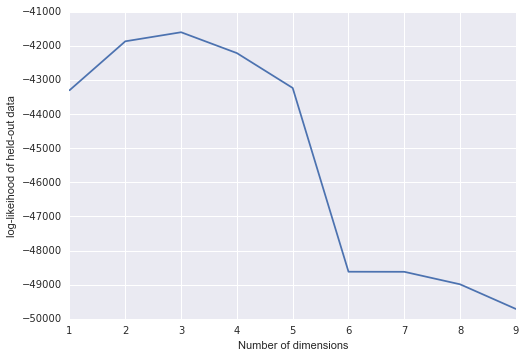

In [122]:
meanll=numpy.zeros(10)
dimvals=[]
for i in range(1,10):
    files=glob.glob('cvdata/ll_%03d_*'%i)
    if len(files)==0:
        continue
    m=[]
    dimvals.append(i)
    for f in files:
        d=numpy.loadtxt(f)
        m.append(numpy.mean(d))
    meanll[i]=numpy.mean(m)

plt.plot(dimvals,meanll[1:])
plt.xlabel('Number of dimensions')
plt.ylabel('log-likeihood of held-out data')
print('Crossvalidation suggests %d dimensions'%dimvals[numpy.argmax(meanll[1:])])